### Import dependencies

In [1]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_DIR', "../../") )

#!pip install hippylib
from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121

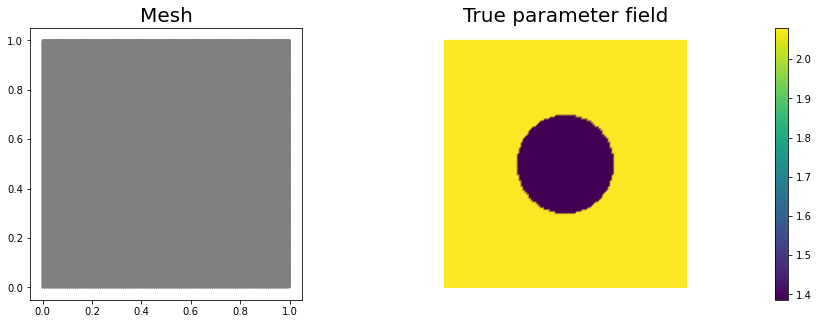

In [2]:
# create mesh and define function spaces
nx = 128
ny = 128
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'CG', 2)
Vu = dl.FunctionSpace(mesh, 'CG', 2)

# The true and initial guess for inverted parameter
mtrue = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
f  = dl.Constant(1.0)
u0 = dl.Constant(0.0)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, u0, boundary)
bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

### Set up synthetic observations:

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{(e^{m_{\text true}} \nabla u,\nabla v)}_{\; := \; a_{\rm true}} - \underbrace{(f,v)}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``ud`` as

$$ u_{d} = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

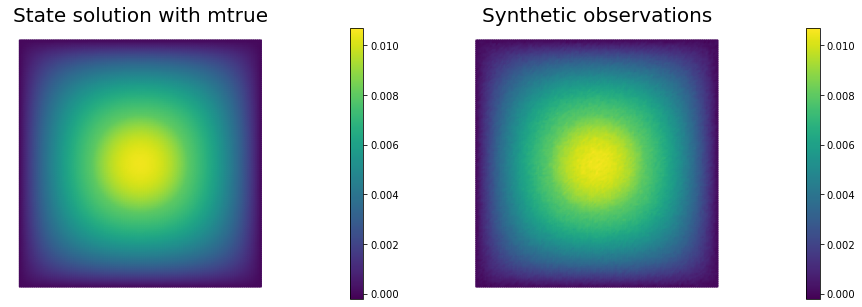

In [4]:
# noise level
noise_level = 0.01

# weak form for setting up the synthetic observations
a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_true = f * u_test * dl.dx

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

ud = dl.Function(Vu)
ud.assign(utrue)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
bc_adj.apply(noise)

ud.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, ud], ["State solution with mtrue", "Synthetic observations"])
plt.show()

### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-u_d)^2\, dx}_{\text misfit} + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text reg}
$$

In [5]:
# Regularization parameter
gamma = 1e-9

# Define cost function
def cost(u, ud, m, gamma):
    reg = 0.5*gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx ) 
    misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
    return [reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appear in the the state/adjoint equations and gradient evaluation.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear forms of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear forms of the adjoint equation, repectively;
- `CTvarf`, `gradRvarf` stand for the contributions to the gradient coming from the PDE and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [6]:
# weak form for setting up the state equation
a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_state = f * u_test * dl.dx

# weak form for setting up the adjoint equations
a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
L_adj = - dl.inner(u - ud, p_test) * dl.dx

# weak form for gradient
CTvarf    = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

# Mass matrix in parameter space
Mvarf    = dl.inner(m_trial, m_test) * dl.dx
M = dl.assemble(Mvarf)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \mathcal{G}(m_0)(\tilde{m})\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


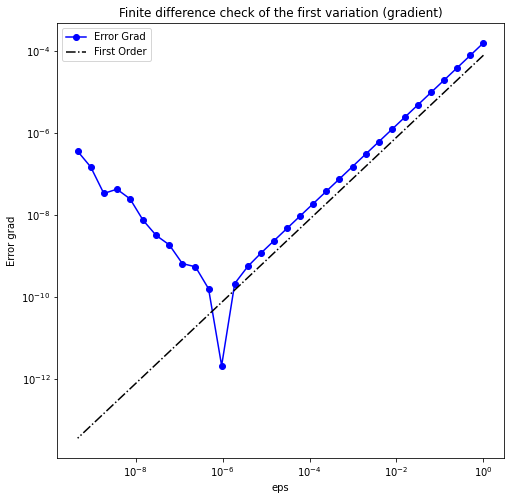

In [7]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, ud, m, gamma)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(CTvarf + gradRvarf)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, ud, m, gamma)
   
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure(figsize = (8,8))    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

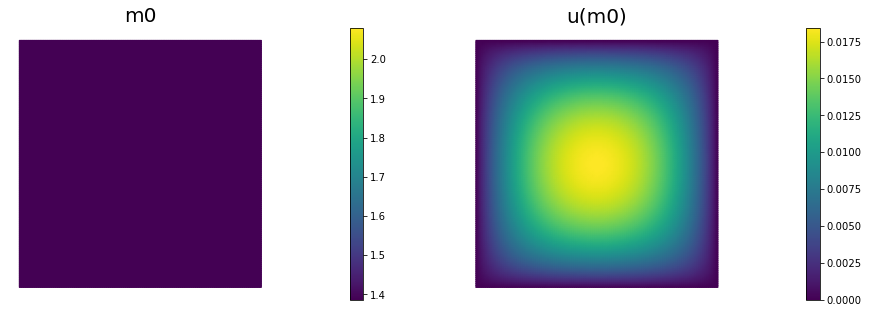

In [8]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equations for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +(\tilde{m}e^m\nabla u, \nabla p).$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} (g,g). $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   1.11686e-05   1.10410e-05   1.27640e-07   6.09067e-05   5.00000e+04     1


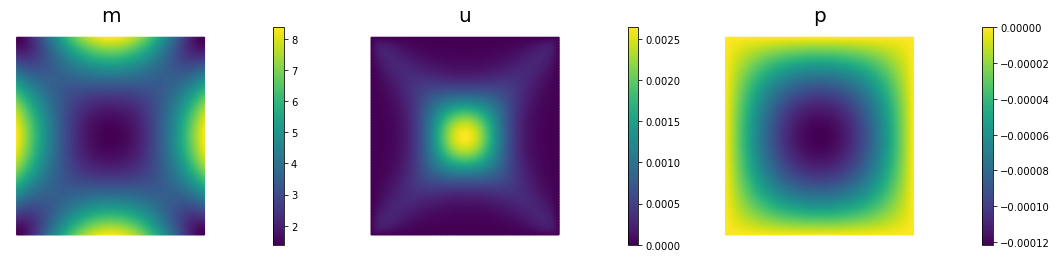

In [ ]:
# define parameters for the optimization
tol = 1e-4
maxiter = 10000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(CTvarf + gradRvarf)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the state/forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset a
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

In [ ]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()

## Another example: advection-diffusion problem

$\def\bv{{\bf v}}$

We modify the problem above by adding an advective term with $\bv = (30,0)^T$:

$$
\begin{split}
\quad -\nabla\cdot(e^m\nabla u)  + \bv \cdot \nabla u &= f \text{ in }\Omega,\\
u &= 0 \text{ on }\partial\Omega.
\end{split}
$$

In [ ]:
def AddDiffInverseProblem(nx, ny, v, gamma, useTV=False, TVeps=None, plotting=False):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess for inverted parameter
    mtrue = dl.interpolate(
            dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5),
                            Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f  = dl.Constant(1.0)
    u0 = dl.Constant(0.0)
    
    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), boundary)
    
    # noise level
    noise_level = 0.01

    # weak form for setting up the synthetic observations
    a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_true = f * u_test * dl.dx

    # solve the forward/state problem to generate synthetic observations
    A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

    utrue = dl.Function(Vu)
    dl.solve(A_true, utrue.vector(), b_true)

    ud = dl.Function(Vu)
    ud.assign(utrue)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)
    
    ud.vector().axpy(1., noise)

    if plotting:
        nb.multi1_plot([utrue, ud], ["State solution with mtrue", "Synthetic observations"])
        plt.show()
    
    # Define cost function
    def cost(u, ud, m, gamma):
        if useTV:
            reg = gamma * dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps)*dl.dx ) 
        else:
            reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
            
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]
    
    # weak form for setting up the state equation
    a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
              + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_state = f * u_test * dl.dx

    # weak form for setting up the adjoint equations
    a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx \
            + dl.dot(v, dl.grad(p_test))*p_trial*dl.dx
    L_adj = - dl.inner(u - ud, p_test) * dl.dx

    # weak form for gradient
    CTvarf    = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
    if useTV:
        gradRvarf = ( dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps) )* \
                     dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
    else:
        gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # Mass matrix in parameter space
    Mvarf    = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(Mvarf)
    
    m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )
    
    m.assign(m0)

    # solve state equation
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)

    if plotting:
        plt.figure(figsize=(15,5))
        nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
        nb.plot(u,subplot_loc=122, mytitle="u(m0)")
        plt.show()

    tol = 1e-4
    maxiter = 10000
    c_armijo = 1e-5

    # initialize iter counters
    iter = 0
    converged = False

    # initializations
    g = dl.Vector()
    M.init_vector(g,0)

    m_prev = dl.Function(Vm)

    while iter <  maxiter and not converged:

        # solve the adoint problem
        adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        dl.solve(adj_A, p.vector(), adjoint_RHS)

        # evaluate the  gradient
        MG = dl.assemble(CTvarf + gradRvarf)
        dl.solve(M, g, MG)

        # calculate the norm of the gradient
        grad_norm2 = g.inner(MG)
        gradnorm = np.sqrt(grad_norm2)
    
        if iter == 0:
            gradnorm0 = gradnorm

        # linesearch
        it_backtrack = 0
        m_prev.assign(m)
        alpha = 1.e5
        backtrack_converged = False
        for it_backtrack in range(20):
        
            m.vector().axpy(-alpha, g )

            # solve the state/forward problem
            state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
            dl.solve(state_A, u.vector(), state_b)

            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old - alpha * c_armijo * grad_norm2:
                cost_old = cost_new
                backtrack_converged = True
                break
            else:
                alpha *= 0.5
                m.assign(m_prev)  # reset a
            
        if backtrack_converged == False:
            print( "Backtracking failed. A sufficient descent direction was not found" )
            converged = False
            break
    
        # check for convergence
        if gradnorm < tol*gradnorm0 and iter > 0:
            converged = True
            print ("Steepest descent converged in ",iter,"  iterations")
        
        iter += 1
    
    if not converged:
        print ( "Steepest descent did not converge in ", maxiter, " iterations")
        
    if plotting:
        nb.multi1_plot([mtrue, m], ["mtrue", "m"])
        nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
        plt.show()
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)
    return Vm.dim(), iter, noise_norm2, cost_new, misfit_new, reg_new

We find the optimal value of the regularization parameter using Morozov's discrepancy principle.

In [ ]:
n = 16
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
misfits = []

for gamma in gammas:
    ndof, niter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),
                                         gamma = gamma, useTV=False, plotting=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()

print("Solve for gamma = ", 1e-9)
_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-9, useTV=False, plotting=True)

We study the behavior of the algorithm by solving the problem with $8 \times 8$, $16 \times 16$, $32 \times 32$, $64 \times 64$ finite elements. We observe that the number of interations increases as we refine the mesh. Thus, steepest descent method is not scalable with respect to the parameter dimension.

In [ ]:
ns = [8, 16, 64, 128]
niters = []
ndofs  = []

for n in ns:
    ndof, niter, _,_,_,_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),
                                         gamma = 1e-9, useTV=False, plotting=False)
    niters.append(niter)
    ndofs.append(ndof)
    
plt.figure(figsize=(8,8))    
plt.semilogx(ndofs, niters)
plt.ylim([0, 10000])
plt.title("Number of iterations")
plt.xlabel("Parameter dimension")
plt.ylabel("Number of iterations")
plt.show()

## Total Variation regularization

Since the coefficient $m$ is discontinuous, a better choice of regularization is Total Variation (TV) rather than Tikhonov regularization, to prevent an overly smooth reconstruction:

$$ \mathcal{R}_{\rm TV}^\varepsilon = \gamma \int_\Omega (\nabla m \cdot \nabla m + \varepsilon)^{\frac{1}{2}}\, dx.
$$
To make the non-differentiable TV regularization term differentiable, we use $\epsilon=0.1$.

In [ ]:
n = 16
gammas = [1e-8, 1e-9, 1e-10]
misfits = []

for gamma in gammas:
    ndof, niter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),
                                         gamma = gamma, useTV=True, TVeps=dl.Constant(0.1), plotting=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()

print("Solve for gamma = ", 1e-8)
_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-8, useTV=True,
                      TVeps=dl.Constant(0.1), plotting=True)

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright (c) 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.